<a href="https://colab.research.google.com/github/nadav-amir/hddm/blob/master/states_as_goals_directed_concepts_delay_and_amount_conds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install hssm
#!pip install numba

In [ ]:
# @title Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import choices
import pandas as pd
import os
#import hssm
import seaborn as sns
import scipy.optimize as optimize
#from numba import jit
from collections import Counter
import pickle


In [ ]:
# bandit analysis
N_OBS = 3
N_ACT = 4

O = range(N_OBS)
A = range(N_ACT)

pi = np.zeros([N_OBS,N_ACT]) # policy matrix (rows are observations, columns are actions)
for row_i in O:
  prob_vector = np.random.dirichlet(np.ones(N_ACT))
  #T = np.row([T, prob_vector])
  pi[row_i,:]=prob_vector

e = np.zeros([N_ACT,N_OBS]) # environemnt matrix (rows are action, columns are observations)
for row_i in A:
  prob_vector = np.random.dirichlet(np.ones(N_OBS))
  #T = np.row([T, prob_vector])
  e[row_i,:]=prob_vector

num2act = {a_num:'a_'+str(a_num) for a_num in A}
num2obs = {o_num:'o_'+str(o_num) for o_num in O}

act2num = {v: k for k, v in num2act.items()}
obs2num = {v: k for k, v in num2obs.items()}


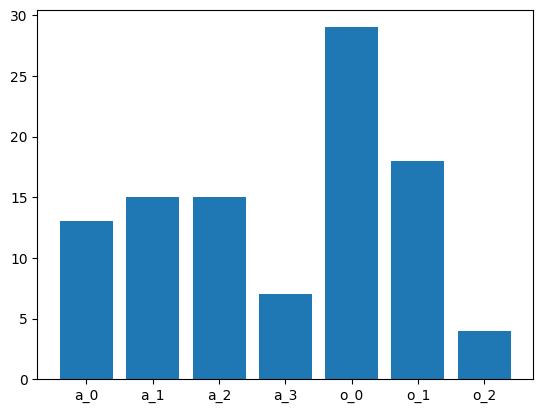

In [ ]:
N_H = 100

h=[]
#h.append(num2obs[np.random.choice(O)]) # randomly choose initial observation
h.append(num2obs[0])
for t in range(1,N_H,2):
  # choose next action based on previous observation
  cur_action = num2act[np.random.choice(A,1,p=pi[obs2num[h[t-1]],:])[0]]
  h.append(cur_action) # randomly action based on previous observation
  # chose next observation
  next_obs = num2obs[np.random.choice(O,1,p=e[act2num[h[t]],:])[0]]
  h.append(next_obs) # randomly action based on previous observation


count_dict = Counter(h)
count_dict = dict(sorted(count_dict.items()))

trans_count_dict = dict(Counter(zip(h[:-1], h[1:])))
trans_count_dict = dict(sorted(trans_count_dict.items()))


plt.bar(count_dict.keys(),count_dict.values())

trans_count_dict_norm = {}
for key, value in trans_count_dict.items():
  trans_count_dict_norm[key] = 2*value/N_H



In [ ]:
# empirical_pi = {}
# empirical_e = {}
# for o_i in O:
#   o = num2obs[o_i]
#   for a_j in A:
#     a = num2act[a_j]
#     key = (o,a)
#     empirical_pi[key] = trans_count_dict[key]/np.sum([trans_count_dict[k] for k in trans_count_dict.keys() if k[1]==o]) # recreate empirical policy

# for a_j in A:
#   a = num2act[a_j]
#   for o_i in O:
#     o = num2obs[o_i]
#     key = (a,o)
#     empirical_e[key] = trans_count_dict[key]/np.sum([trans_count_dict[k] for k in trans_count_dict.keys() if k[0]==a]) # recreate empirical environment

# empirical_pi_matrix = np.array([empirical_pi[i] for i in empirical_pi.keys()]).reshape(N_OBS,N_ACT)
# empirical_e_matrix = np.array([empirical_e[i] for i in empirical_e.keys()]).reshape(N_ACT,N_OBS)

# print(pi)
# print(empirical_pi_matrix)
# print(e)
# print(empirical_e_matrix)

In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Constants and helper functions

#OBSERVATIONS = ['odor_left','odor_right','odor_free'] # possible observations: left odor, right odor, free choice odor
#OUTCOMES = ['short_delay','long_delay','no_liquid'] # possible outcomes: earaly liquid, delayed liquid, no liquid
ACTIONS = ['poke_left','poke_right'] # possible actions: left port poke, right port poke
#BLOCK_TYPE = ['short_left','short_right'] # is the early liquid available in the left or right odor port

# def histEvalObsToActTransitions(h,beta_weights_trans_dict):
#   """Evalute a given history for transition counts"""
#   transition_count_dict = {}
#   for o,a in beta_weights_trans_dict.keys():
#     count = 0
#     for i in range(len(h) - 1):
#       if h[i] == o  and h[i + 1] == a:
#         count += 1
#     transition_count_dict[o,a] = count
#   return dot_product_dict(beta_weights_trans_dict,transition_count_dict)

def histEval(h,beta_dict):
  """Evalute a given history"""
  if isinstance(list(beta_dict.keys())[0],tuple): # transition counts
    transition_count_dict = {}
    for o,a in beta_dict.keys():
      count = 0
      for i in range(len(h) - 1):
        if h[i] == o  and h[i + 1] == a:
          count += 1
      transition_count_dict[o,a] = count
    return dot_product_dict(beta_dict,transition_count_dict)
  else: # observation/action counts
    beta_val_list = list(beta_dict.values())
    counts = [h.count(k) for k in list(beta_dict.keys())]

    # count differences: left-right, big-small, short-long
    counts = [h.count(k[0])-h.count(k[1]) for k in zip(list(beta_dict.keys())[::2],list(beta_dict.keys())[1::2])]

    beta_val_list = [k[0]-k[1] for k in zip(beta_val_list[::2],beta_val_list[1::2])]
    return np.dot(beta_val_list,counts)

def getStateSeq(h,beta_dict):
  """Compute state sequence by travesering the given history sequence"""
  state_sequence = []
  #beta_val_list = list(beta_dict.values())
  for i in range(len(h)):
    sub_h = h[0:i]
    state_sequence.append(histEval(sub_h,beta_dict))
  return state_sequence

def histEquiv(h1,h2,histEvalFunc):
  """determine whether two histories are equivalent"""
  return (histEvalFunc(h1)==histEvalFunc(h2))

def dot_product_dict(dict1, dict2):
    """compute dot product for two dictionaries with overlapping keys"""
    result = 0
    for key in dict1.keys() & dict2.keys():
        result += dict1[key] * dict2[key]
    return result


def calcOutcome(observation, action, block_type):
  """Return the liquid administration outcome for a given observation, action pair and a given block-type"""
  if block_type == 'short_long':
    if observation == 'odor_left':
      if action == 'poke_left':
        return 'short_delay'
      elif action == 'poke_right':
        return 'no_liquid'
    elif observation == 'odor_right':
      if action == 'poke_left':
        return 'no_liquid'
      elif action == 'poke_right':
        return 'long_delay'
    elif observation == 'odor_free':
      if action == 'poke_left':
        return 'short_delay'
      elif action == 'poke_right':
        return 'long_delay'
  elif block_type == 'long_short':
    if observation == 'odor_left':
      if action == 'poke_left':
        return 'long_delay'
      elif action == 'poke_right':
        return 'no_liquid'
    elif observation == 'odor_right':
      if action == 'poke_left':
        return 'no_liquid'
      elif action == 'poke_right':
        return 'short_delay'
    elif observation == 'odor_free':
      if action == 'poke_left':
        return 'long_delay'
      elif action == 'poke_right':
        return 'short_delay'
  elif block_type == 'big_small':
    if observation == 'odor_left':
      if action == 'poke_left':
        return 'big_amount'
      elif action == 'poke_right':
        return 'no_liquid'
    elif observation == 'odor_right':
      if action == 'poke_left':
        return 'no_liquid'
      elif action == 'poke_right':
        return 'small_amount'
    elif observation == 'odor_free':
      if action == 'poke_left':
        return 'big_amount'
      elif action == 'poke_right':
        return 'small_amount'
  elif block_type == 'small_big':
    if observation == 'odor_left':
      if action == 'poke_left':
        return 'small_amount'
      elif action == 'poke_right':
        return 'no_liquid'
    elif observation == 'odor_right':
      if action == 'poke_left':
        return 'no_liquid'
      elif action == 'poke_right':
        return 'big_amount'
    elif observation == 'odor_free':
      if action == 'poke_left':
        return 'small_amount'
      elif action == 'poke_right':
        return 'big_amount'



def remove_consecuitve_tail(history, beta_dict):
  state_seq = getStateSeq(emp_h,beta_dict);
  i=1
  while state_seq[-1-i]==state_seq[-1-i+1]: # findgin trailing consecutive repeats
    i+=1
  i+=1
  return(history[0:-i])

def calc_neg_allign_coeff(emp_h,beta_dict,beta_weights):
  beta_keys = beta_dict.keys()
  #beta_dict.update(zip(beta_keys,beta_weights))
  emp_cur_state_seq = getStateSeq(emp_h,dict(zip(beta_keys,beta_weights)));
  curr_allign_coeff = emp_cur_state_seq[-1]/len(emp_cur_state_seq) # linear drift rate
  return -curr_allign_coeff

def apply_norm_constraint(inputs):
    #return value must come back as 0 to be accepted
    #if return value is anything other than 0 it's rejected
    #as not a valid answer.

    total = 1-np.sqrt(np.sum(np.square(inputs)))
    #total = 1-np.sum(np.exp(inputs))
    return total

my_constraints = ({'type': 'eq', "fun": apply_norm_constraint })

def get_best_beta_vals(emp_h,beta_dict):
  cur_opt_beta = lambda x: calc_neg_allign_coeff(emp_h,beta_dict,x)
  x0 = list(beta_dict.values())
  res=optimize.minimize(cur_opt_beta, x0, constraints=my_constraints)
  return(res.x)

def callbackF(emp_h,beta_dict,Xi):
    global Nfeval
    cur_opt_beta = lambda x: calc_neg_allign_coeff(emp_h,beta_dict,x)
    if Nfeval==1:
      print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}   {5:9s}   {6:9s}   {7:9s}   {8:9s}   {9:9s}   {10:9s}'.format('Iter', 'odor_left', 'odor_right', 'odor_free', 'poke_left', 'poke_right', 'no_poke', 'short_delay', 'long_delay', 'no_liquid', 'f(X)'))
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}   {6: 3.6f}   {7: 3.6f}   {8: 3.6f}   {9: 3.6f}   {10: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2],Xi[3], Xi[4], Xi[5],Xi[6], Xi[7], Xi[8], cur_opt_beta(Xi)))
    Nfeval += 1

In [ ]:

# load Mingyu paper data
current_directory = os.getcwd()
df = pd.read_csv(current_directory+'/drive/MyDrive/Colab Notebooks/data/takahashi2016roesch2009burton2018Valid.csv')


# dictionaries for converting choice/action/outcome names
actionToChoice = {}
actionToChoice['poke_left'] = 1
actionToChoice['poke_right'] = 2

choiceToAction = {v: k for k, v in actionToChoice.items()}

odorToObservation = {}
odorToObservation['left'] = 'odor_left'
odorToObservation['right'] = 'odor_right'
odorToObservation['free'] = 'odor_free'

observationToOdor = {v: k for k, v in odorToObservation.items()}

trialCondToOutcome = {}
trialCondToOutcome['short_left'] = 'short_delay'
trialCondToOutcome['short_right'] = 'short_delay'
trialCondToOutcome['long_left'] = 'long_delay'
trialCondToOutcome['long_right'] = 'long_delay'
trialCondToOutcome['big_left'] = 'big_amount'
trialCondToOutcome['big_right'] = 'big_amount'
trialCondToOutcome['small_left'] = 'small_amount'
trialCondToOutcome['small_right'] = 'small_amount'
trialCondToOutcome['none'] = 'no_liquid'


outcomeToTrialCond = {v: k for k, v in trialCondToOutcome.items()}

all_empirical_histories_in_block = []


selected_observations = {}
selected_actions = {}
selected_outcomes = {}
selected_block_types = {} # need to know block type of each trial for creating simulated data

# also keep actual delays and amounts (for tradeoff model)
selected_delays = {}
selected_amounts = {}
all_empirical_histories_in_block_delay_amount = []

N_HISTORY = int(400/3) # experience history length (n*(observation,action) tuples)
N_TRIALS = 30 # number of trials in block
N_BLOCKS = 6 # number of blocks
N_RATS = 20 # number of rats for empirical dataset

for i_rat in range(1,N_RATS+1):
  rat_list = [i_rat]
  session_list = [1]
  condition_list = ['short_left','short_right','long_left','long_right','big_left','big_right','small_left','small_right',float('nan')]
  trial_type_list = ['valid']
  selected_df = df.loc[df['rat'].isin(rat_list) & df['session'].isin(session_list) & df['trialCond'].isin(condition_list) & df['trialType'].isin(trial_type_list)]

  selected_df['trialCond'].fillna('none',inplace=True) # replace nans in trialCond column with 'none'

  selected_observations[i_rat] = [odorToObservation[v] for v in selected_df['odor']]
  selected_actions[i_rat] = [choiceToAction[v] for v in selected_df['choice']]
  selected_outcomes[i_rat] = [trialCondToOutcome[v] for v in selected_df['trialCond']]
  selected_block_types[i_rat] = list(selected_df['blockType'])

  selected_delays[i_rat] = [v for v in selected_df['rewardDelay']]
  selected_amounts[i_rat] = [v for v in selected_df['rewardAmount']]

  selected_lists = [selected_observations[i_rat], selected_actions[i_rat], selected_outcomes[i_rat]] # temporary list for interleaving observation, actions and outcomes into histories
  selected_history = [val for tup in zip(*selected_lists) for val in tup]

  selected_lists_delay_amount = [selected_delays[i_rat],selected_amounts[i_rat]]
  selected_history_delay_amount = [val for tup in zip(*selected_lists_delay_amount) for val in tup]

  all_empirical_histories_in_block.append(selected_history);
  all_empirical_histories_in_block_delay_amount.append(selected_history_delay_amount)


<ipython-input-9-6aeaf9312c59>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['trialCond'].fillna('none',inplace=True) # replace nans in trialCond column with 'none'


In [ ]:
df.head(100)

,dataset,rat,session,sessionType,trial,block,blockType,odor,choice,rewardAmount,rewardDelay,trialType,trialCondCode,trialCond,odorEntryRT,odorExitRT,wellEntryRT,wellExitRT
0,takahashi2016,1,1,leftBetterFirst,4,1,short_long,left,1,1,0.502000,valid,5.0,short_left,4.566050,0.776025,0.329050,3.814075
1,takahashi2016,1,1,leftBetterFirst,6,1,short_long,left,1,1,0.502050,valid,5.0,short_left,0.543000,0.762025,0.399000,4.194075
2,takahashi2016,1,1,leftBetterFirst,8,1,short_long,right,1,0,NaN,valid,NaN,NaN,1.490075,0.797000,0.498050,0.000000
3,takahashi2016,1,1,leftBetterFirst,9,1,short_long,right,1,0,NaN,valid,NaN,NaN,1.122000,0.622050,0.108025,0.000000
4,takahashi2016,1,1,leftBetterFirst,12,1,short_long,right,2,1,1.002025,valid,8.0,long_right,1.243025,0.552975,0.610025,3.089100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,takahashi2016,1,1,leftBetterFirst,124,2,long_short,right,2,1,0.502025,valid,6.0,short_right,1.053025,0.669025,0.425000,3.097075
96,takahashi2016,1,1,leftBetterFirst,125,2,long_short,right,2,1,0.502025,valid,6.0,short_right,0.841025,0.787000,0.318000,3.519100
97,takahashi2016,1,1,leftBetterFirst,128,2,long_short,free,2,1,0.502000,valid,6.0,short_right,0.708000,0.666025,0.120025,3.306075
98,takahashi2016,1,1,leftBetterFirst,130,2,long_short,left,1,1,4.002050,valid,7.0,long_left,0.611025,0.614025,0.138025,2.604075


In [ ]:
w = np.abs(np.random.normal(0, 1, 6))

beta_dict = {'poke_left': w[0], 'poke_right': w[1],
             'short_delay': w[2], 'long_delay': w[3],
             'big_amount': w[4], 'small_amount': w[5]}
print(list(beta_dict.keys())[1::2])
h = selected_history
[h.count(k[0])-h.count(k[1]) for k in zip(list(beta_dict.keys())[::2],list(beta_dict.keys())[1::2])]


beta_val_list = list(beta_dict.values())
[k[0]-k[1] for k in zip(beta_val_list[::2],beta_val_list[1::2])]

['poke_right', 'long_delay', 'small_amount']


[0.5644886694180866, -1.8736520207548084, -0.1422653110466942]

<ipython-input-12-dc8b04000215>:167: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Simulated','Empirical')


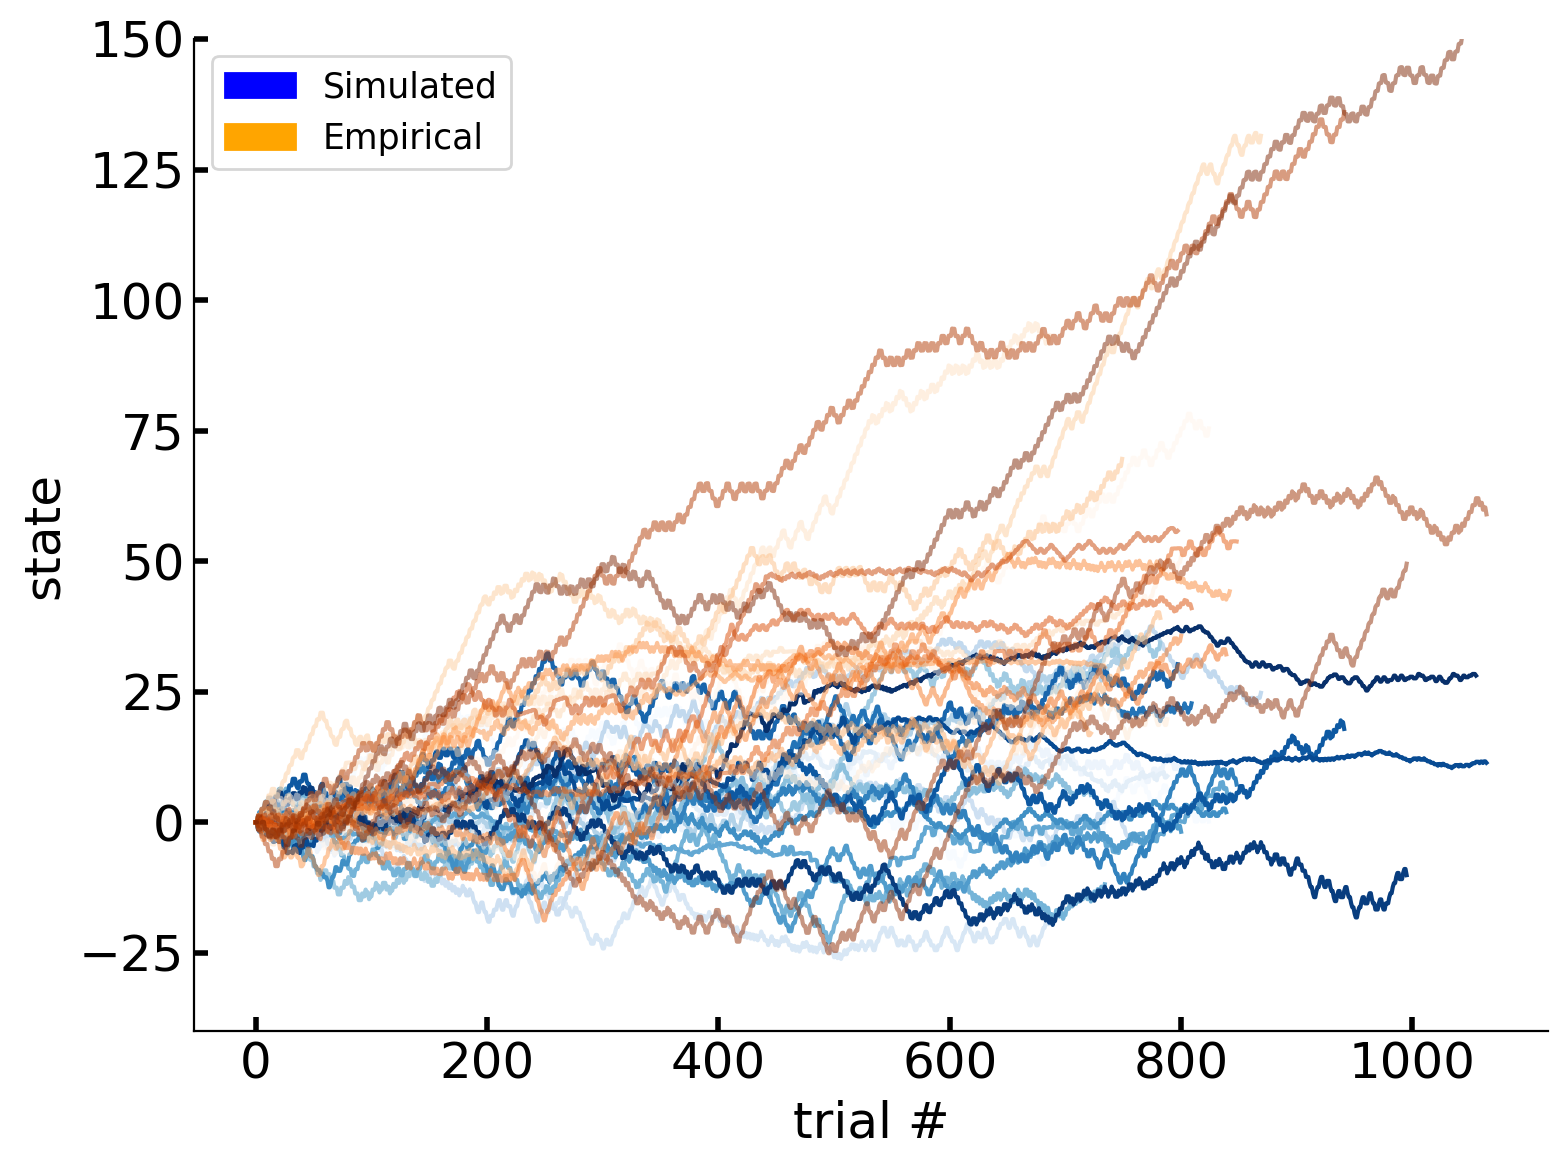

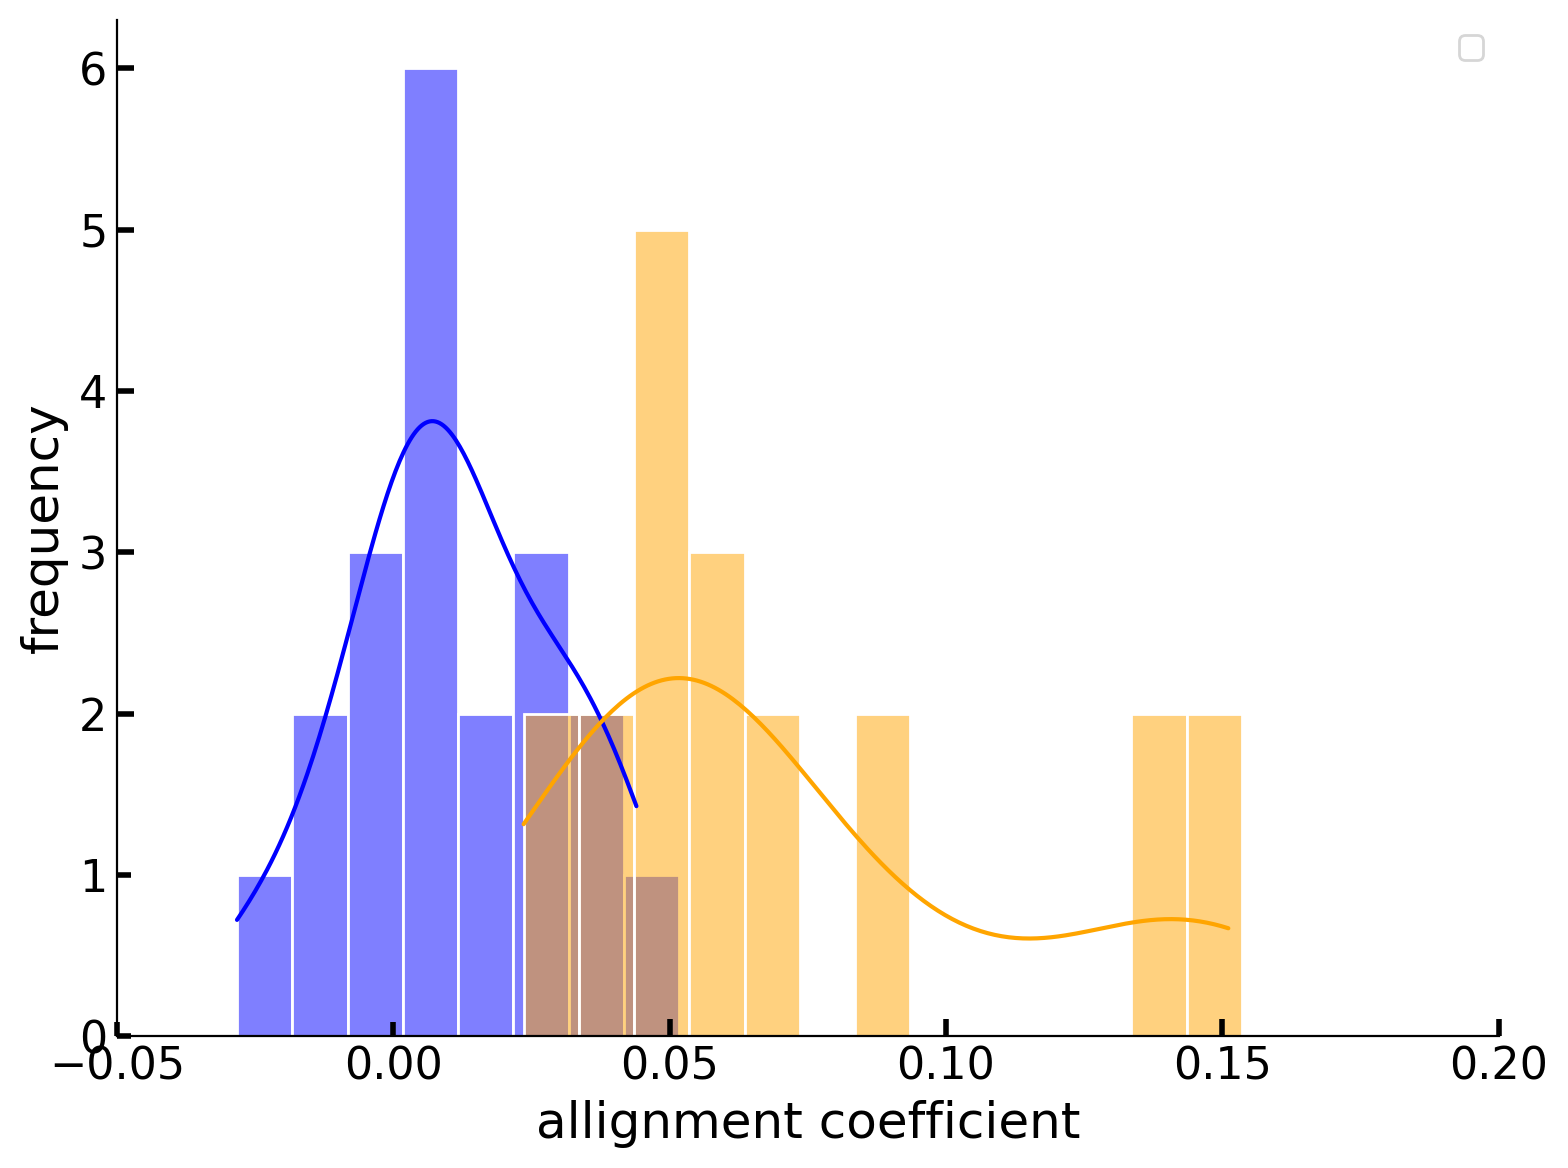

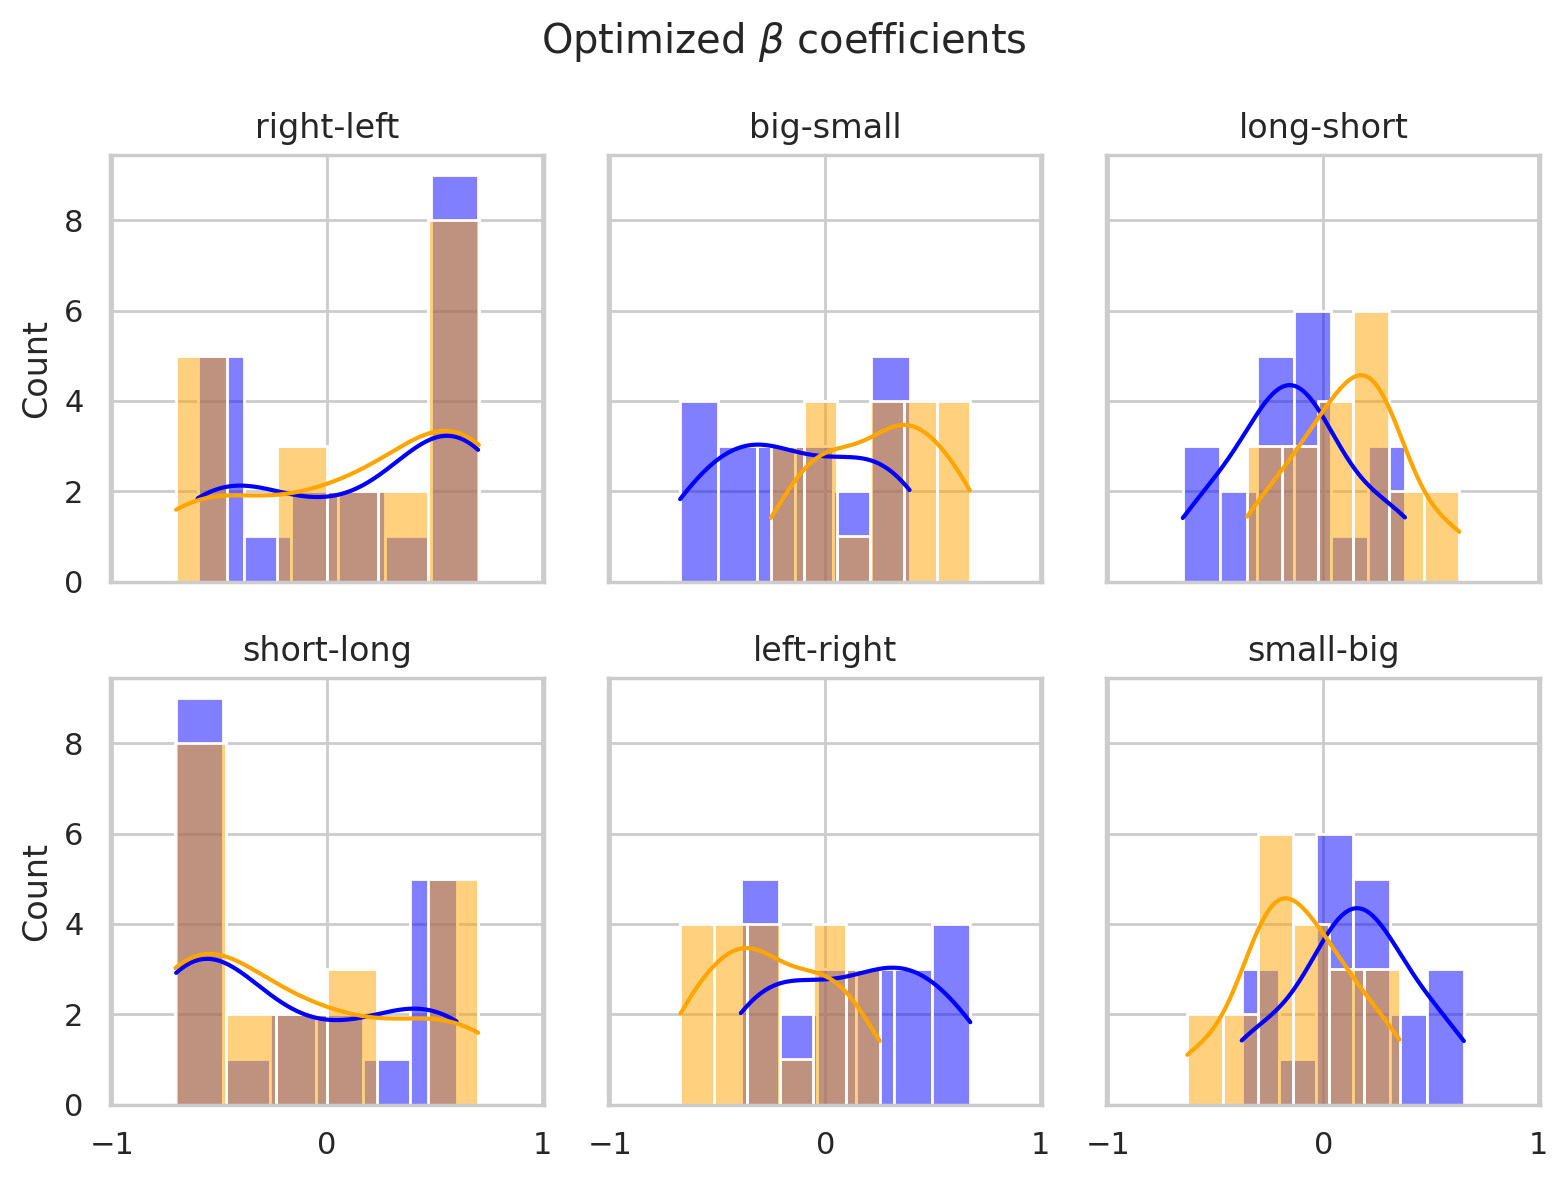

In [ ]:
#from matplotlib.legend import PathCollection

optimize_beta = True # find the best beta values for each rat or use the predefined ones for all rats

if optimize_beta == False:
  save_best_beta_vals = False # save optimzed beta values
  load_best_beta_vals = False # load previously saved best beta values
else:
  save_best_beta_vals = False # save optimzed beta values
  load_best_beta_vals = True # load previously saved best beta values


#block_type = 'short_left'

# history counter weights (odor_left,odor_right,odor_free,poke_left,poke_right,no_poke,short_delay,long_delay,no_liquid)
beta_dict = {'odor_left': 0, 'odor_right': 0, 'odor_free': 0,
             'poke_left': 0, 'poke_right': 0, 'no_poke': 0,
             'short_delay': 1, 'long_delay': -1,
             'big_amount': 1, 'small_amount': -1,
             'no_liquid': 0}


w = np.abs(np.random.normal(0, 1, 6))
w = w/np.sqrt(np.sum(np.square(w)))
#w = [ 0.7124607 , -0.53408641,  0.01088001,  0.3414571 , -0.00447377, -0.30069937]
w = [1,-1,1,-1,1,-1]/np.sqrt(6)

beta_dict = {'poke_right': w[0], 'poke_left': w[1],
             'short_delay': w[2], 'long_delay': w[3],
             'big_amount': w[4], 'small_amount': w[5]}

beta_dict_transitions = {('odor_left', 'poke_left'): 1,
 ('odor_left', 'poke_right'): -1,
 ('odor_left', 'no_poke'): 0,
 ('odor_right', 'poke_left'): -1,
 ('odor_right', 'poke_right'): 1,
 ('odor_right', 'no_poke'): 0,
 ('odor_free', 'poke_left'): 0.5,
 ('odor_free', 'poke_right'): 0.5,
 ('odor_free', 'no_poke'): 0}

# remove consecutive tails
all_empirical_histories_in_block_no_tail = []
#for emp_h in all_empirical_histories_in_block:
#  all_empirical_histories_in_block_no_tail.append(remove_consecuitve_tail(emp_h,beta_dict))

all_simulated_histories_in_block = []
for i_rat in range(N_RATS):
  #observations = choices(OBSERVATIONS, k=N_HISTORY, weights=[1/3,1/3,1/3])
  #CUR_SIM_LEN = int(len(all_empirical_histories_in_block_no_tail[i_rat])/3) # equalize empirical and simulated history lengths
  CUR_SIM_LEN = int(len(all_empirical_histories_in_block[i_rat])/3) # equalize empirical and simulated history lengths

  block_types = selected_block_types[i_rat+1] # rat dict indices start at 1
  observations = selected_observations[i_rat+1] # use true observation sequence
  actions = choices(ACTIONS, k=CUR_SIM_LEN, weights=[1/2,1/2])
  outcomes= list(map(calcOutcome, observations, actions, block_types))
  lists = [observations, actions, outcomes]
  sim_history = [val for tup in zip(*lists) for val in tup]
  all_simulated_histories_in_block.append(sim_history)

xmin,xmax = [0,N_HISTORY*3]

# allignment coefficients (how much is the behavior of each mouse allgined with the current goal)
sim_allign_coeff_list = []
emp_allign_coeff_list = []

sim_cur_state_seq_list = []
emp_cur_state_seq_list = []

best_beta_vals_sim = {}
best_beta_vals_emp = {}

filepath_best_betas_sim = r'drive/MyDrive/Colab Notebooks/SAGDC/best_beta_vals_sim.pkl'
filepath_best_betas_emp = r'drive/MyDrive/Colab Notebooks/SAGDC/best_beta_vals_emp.pkl'

if load_best_beta_vals:
  with open(filepath_best_betas_sim, "rb") as fp:   # Unpickling
    best_beta_vals_sim = pickle.load(fp)
  with open(filepath_best_betas_emp, "rb") as fp:   # Unpickling
    best_beta_vals_emp = pickle.load(fp)

for sim_i, sim_h in enumerate(all_simulated_histories_in_block):
  if optimize_beta:
    if not load_best_beta_vals:
      best_beta_vals_sim[sim_i] = get_best_beta_vals(sim_h,beta_dict)
    best_beta_dict = dict(zip(beta_dict.keys(),best_beta_vals_sim[sim_i]))
    beta_dict = best_beta_dict
  else:
    w = np.abs(np.random.normal(0, 1, 6))
    w = w/np.sqrt(np.sum(np.square(w)))
    beta_dict = {'poke_right': w[0], 'poke_left': w[1],
             'short_delay': w[2], 'long_delay': w[3],
             'big_amount': w[4], 'small_amount': w[5]}

  sim_cur_state_seq = getStateSeq(sim_h,beta_dict);
  sim_cur_state_seq_list.append(sim_cur_state_seq)
  # fig_sim = sns.lineplot(sim_cur_state_seq)
  # ax_sim = plt.gca()
  # title = plt.title(r'$N={}$ rats - simulated behavior (uniform) $\beta$={}'.format(N_RATS,beta_weights))
  # #title = plt.title(r'simulated behavior $\beta$={}'.format(N_RATS,beta))
  # x_label = plt.xlabel('trial #')
  # y_label = plt.ylabel('state')
  # #x_label.set_fontsize(14)
  # #y_label.set_fontsize(14)
  # plt.tick_params(axis='both', which='major', labelsize=14,
  #               width=2, color='black', direction='in')
  # y_limits_sim = ax_sim.get_ylim()

  #curr_allign_coeff = np.corrcoef(sim_cur_state_seq,range(len(sim_cur_state_seq)))[0,1] # correlation with line
  curr_allign_coeff = sim_cur_state_seq[-1]/len(sim_cur_state_seq) # linear drift rate
  sim_allign_coeff_list.append(curr_allign_coeff)

if save_best_beta_vals:
  with open(filepath_best_betas_sim, "wb") as fp:   #Pickling
    pickle.dump(best_beta_vals_sim, fp)


#fig_emp = plt.figure()
#sns.set_palette("Oranges")
#for emp_h in all_empirical_histories_in_block_no_tail:
for emp_i,emp_h in enumerate(all_empirical_histories_in_block):
  if optimize_beta:
    if not load_best_beta_vals:
      best_beta_vals_emp[emp_i] = get_best_beta_vals(emp_h,beta_dict)
    best_beta_dict = dict(zip(beta_dict.keys(),best_beta_vals_emp[emp_i]))
    beta_dict = best_beta_dict
  else:
    w = np.abs(np.random.uniform(0, 1, 6))
    w = w/np.sqrt(np.sum(np.square(w)))
    beta_dict = {'poke_right': w[0], 'poke_left': w[1],
             'short_delay': w[2], 'long_delay': w[3],
             'big_amount': w[4], 'small_amount': w[5]}

  emp_cur_state_seq = getStateSeq(emp_h,beta_dict);
  emp_cur_state_seq_list.append(emp_cur_state_seq)


  # fig_emp = sns.lineplot(emp_cur_state_seq)
  # ax_emp = plt.gca()
  # title = plt.title(r'$N={}$ rats - empirical behavior $\beta$={}'.format(N_RATS,beta_weights))
  # #title = plt.title(r'empirical behavior $\beta$={}'.format(N_RATS,beta))
  # x_label = plt.xlabel('trial #')
  # y_label = plt.ylabel('state')
  # #x_label.set_fontsize(14)
  # #y_label.set_fontsize(14)
  # plt.tick_params(axis='both', which='major', labelsize=14,
  #               width=2, color='black', direction='in')
  # y_limits_emp = ax_emp.get_ylim()

  curr_allign_coeff = emp_cur_state_seq[-1]/len(emp_cur_state_seq) # linear drift rate

  emp_allign_coeff_list.append(curr_allign_coeff)

if save_best_beta_vals:
  with open(filepath_best_betas_emp, "wb") as fp:   #Pickling
    pickle.dump(best_beta_vals_emp, fp)


fig_state_seq, ax_state_seq = plt.subplots()
color_blues = plt.cm.Blues(np.linspace(0, 1, len(sim_cur_state_seq_list)))
for i_sim, sim_h_state_seq in enumerate(sim_cur_state_seq_list):
  plt.plot(sim_h_state_seq,c=color_blues[i_sim])

color_oranges = plt.cm.Oranges(np.linspace(0, 1, len(emp_cur_state_seq_list)))
for i_emp, emp_h_state_seq in enumerate(emp_cur_state_seq_list):
  plt.plot(emp_h_state_seq,c=color_oranges[i_emp], alpha = 0.5)
plt.legend('Simulated','Empirical')

x_label = plt.xlabel('trial #', fontsize = 18)
y_label = plt.ylabel('state', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18, width=2, color='black', direction='in')
sim_patch = mpatches.Patch(color='blue', label='Simulated')
emp_patch = mpatches.Patch(color='orange', label='Empirical')
plt.legend(handles=[sim_patch,emp_patch])
# # compute and set joint ylim range for both plots
# y_lim_joint = (min(y_limits_emp[0],y_limits_sim[0]),max(y_limits_emp[1],y_limits_sim[1]))
# ax_sim.set_ylim(y_lim_joint)
# ax_emp.set_ylim(y_lim_joint)
ax_state_seq.set_ylim([-40,150])

fig_allign, ax_allign = plt.subplots()
sns.set(style="whitegrid")
sns.histplot(sim_allign_coeff_list, binwidth=0.01, kde=True, color='blue', ax=ax_allign)
sns.histplot(emp_allign_coeff_list, binwidth=0.01, kde=True, color='orange', ax=ax_allign, alpha = 0.5)

# Add labels and legend
plt.xlabel('allignment coefficient', fontsize = 18)
plt.ylabel('frequency', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=16, width=2, color='black', direction='in')
ax_allign.legend()
ax_allign.set(xlim=(-0.05,0.2))

# Show the plot
plt.show()


# fig_sim_allign = plt.figure()
# plt.hist(sim_allign_coeff_list)
# ax_sim_allign = plt.gca()

# fig_emp_allign = plt.figure()
# plt.hist(emp_allign_coeff_list)
# ax_emp_allign = plt.gca()

# link x-y axis limits
# y_limits_sim = ax_sim_allign.get_ylim()
# x_limits_sim = ax_sim_allign.get_xlim()
# y_limits_emp = ax_emp_allign.get_ylim()
# x_limits_emp = ax_emp_allign.get_xlim()
# y_lim_joint = (min(y_limits_emp[0],y_limits_sim[0]),max(y_limits_emp[1],y_limits_sim[1]))
# x_lim_joint = (min(x_limits_emp[0],x_limits_sim[0]),max(x_limits_emp[1],x_limits_sim[1]))
# ax_sim_allign.set_ylim(y_lim_joint)
# ax_emp_allign.set_xlim(x_lim_joint)

if optimize_beta: # plot optimized beta histograms
  n_features = len(beta_dict.keys())
  sqrt_n_features = int(np.sqrt(n_features))

  fig, axes = plt.subplots(nrows=2, ncols=int(n_features/2), sharey=True, sharex=True)

  all_beta_emp={}
  all_beta_sim={}

  for j in range(len(beta_dict.keys())):

    all_beta_emp[j] = [best_beta_vals_emp[i][j] for i in range(len(all_empirical_histories_in_block))]
    all_beta_sim[j] = [best_beta_vals_sim[i][j] for i in range(len(all_simulated_histories_in_block))]

    #fig = plt.figure()
    #plt.hist(all_beta[j])
    #ax = plt.gca()
    #plt.xlim([0,1])
    #plt.show()
    #fig_beta_hist, ax_beta_hist = plt.subplots()
    ax = sns.histplot(all_beta_sim[j], bins='auto', kde=True, color='blue', ax=axes[j%2, int(j/2)])
    sns.histplot(all_beta_emp[j], bins='auto', kde=True, color='orange', ax=axes[j%2, int(j/2)])


    title_list_diff = ['right-left','short-long','big-small','left-right','long-short','small-big']
    #ax.title.set_text(list(beta_dict.keys())[j])
    ax.title.set_text(title_list_diff[j])

    ax.set(xlim=(-1.01,1.01))

    #axes.set(xlim=(-0.01,0.6))
    # Add labels and legend
    #plt.title(list(beta_dict.keys())[j])
    #plt.ylabel('frequency', fontsize = 18)
    #plt.tick_params(axis='both', which='major', labelsize=16, width=2, color='black', direction='in')

    # Show the plot
    #plt.show()
  fig.suptitle(r'Optimized $\beta$ coefficients')


In [ ]:
filepath_best_betas_sim = r'drive/MyDrive/Colab Notebooks/SAGDC/best_beta_vals_sim.pkl'
filepath_best_betas_emp = r'drive/MyDrive/Colab Notebooks/SAGDC/best_beta_vals_sim.pkl'

if save_best_beta_vals:
  with open(filepath_best_betas_sim, "wb") as fp:   #Pickling
    pickle.dump(best_beta_vals_sim, fp)

if save_best_beta_vals:
  with open(filepath_best_betas_emp, "wb") as fp:   #Pickling
    pickle.dump(best_beta_vals_emp, fp)



In [ ]:
len(emp_allign_coeff_list)

20

In [ ]:
if optimize_beta: # plot optimized beta histograms

  fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True)
  #axes.set_box_aspect(1)

  all_beta_emp={}
  all_beta_sim={}

  for j in range(3):
    all_beta_emp[j] = [best_beta_vals_emp[i][j*2] for i in range(len(all_empirical_histories_in_block))]
    all_beta_sim[j] = [best_beta_vals_sim[i][j*2] for i in range(len(all_simulated_histories_in_block))]

    #fig = plt.figure()
    #plt.hist(all_beta[j])
    #ax = plt.gca()
    #plt.xlim([0,1])
    #plt.show()
    #fig_beta_hist, ax_beta_hist = plt.subplots()
    ax = sns.histplot(all_beta_sim[j], bins=10, kde=True, color='blue', ax=axes[2-j])
    sns.histplot(all_beta_emp[j], bins=10, kde=True, color='orange', ax=axes[2-j])

    #ax.axes.set_title("Title",fontsize=50)
    ax.set_xlabel('Value',fontsize=14)
    ax.set_ylabel('Count',fontsize=14)

    ax.set_box_aspect(1)
    title_list_diff = [r'$\beta^*_3$: right-left ',r'$\beta^*_2$: short-long',r'$\beta^*_1$: big-small','left-right','long-short','small-big']
    #ax.title.set_text(list(beta_dict.keys())[j])
    ax.set_title(title_list_diff[j],fontsize=18)

  #fig.suptitle(r'Optimized $\beta$ coefficients')

NameError: ignored

SkewtestResult(statistic=-1.0031464471879152, pvalue=0.315790207189128)


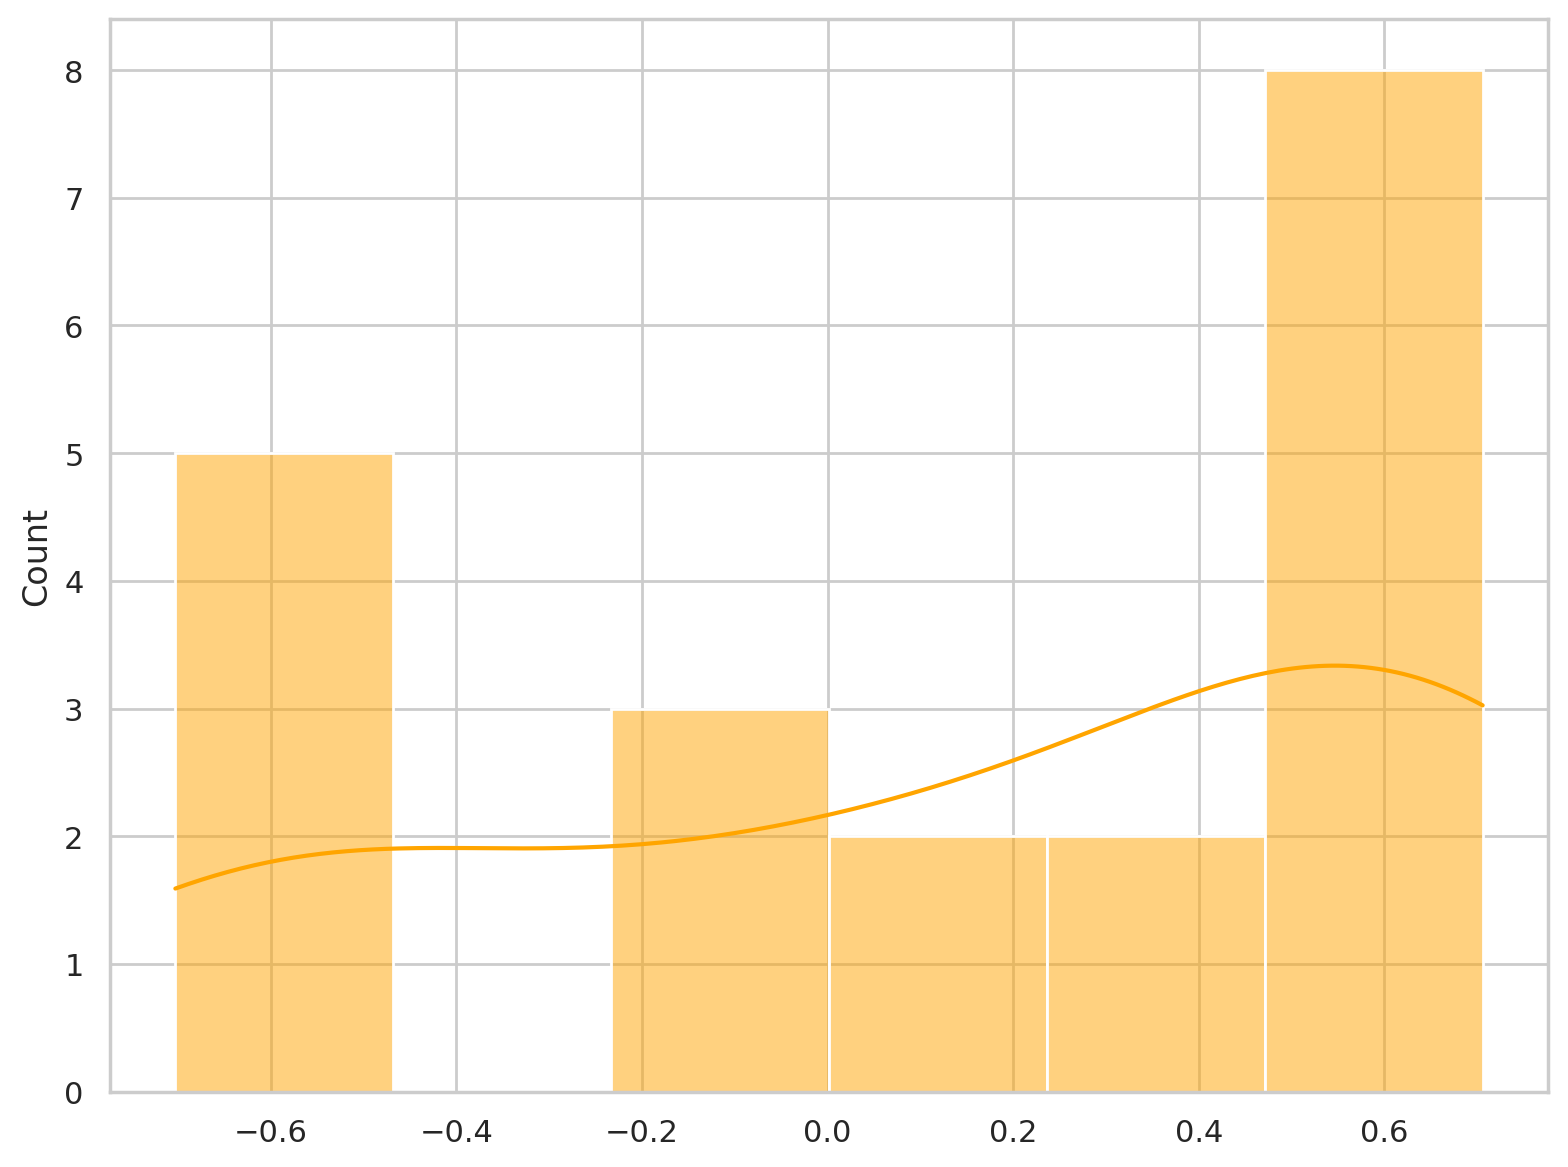

In [ ]:
import scipy.stats as stats

histogram = all_beta_emp[0]
ax = sns.histplot(histogram, bins='auto', kde=True, color='orange')

# Calculate the skewness of the histogram
skewness = stats.skew(histogram)

# Test the significance of the skewness
p_value = stats.skewtest(histogram)

# Print the p-value
print(p_value)

In [ ]:
import scipy.stats as stats
import pprint

beta_tstats={}
beta_pvals={}
for i, beta in enumerate(['right-left','short-long','big-small']):
  data1 = all_beta_sim[i]
  data2 = all_beta_emp[i]
  t_statistic, p_value = stats.ttest_rel(data1, data2)
  beta_tstats[beta]= t_statistic
  beta_pvals[beta] = p_value

pprint.pprint(beta_pvals)

stats.ttest_rel(sim_allign_coeff_list,emp_allign_coeff_list)

{'big-small': 0.0003201002701501439,
 'right-left': 0.9805960413810428,
 'short-long': 0.9805960400374718}


TtestResult(statistic=0.9674004160623804, pvalue=0.3454976477076215, df=19)

In [ ]:
# history counter weights (odor_left,odor_right,odor_free,poke_left,poke_right,no_poke,short_delay,long_delay,no_liquid)
beta_dict = {'odor_left': 0, 'odor_right': 0, 'odor_free': 0,
             'poke_left': 0, 'poke_right': 0, 'no_poke': 0,
             'short_delay': 1, 'long_delay': -1, 'no_liquid': 0}
beta_weights = list(beta_dict.values())

def histEval(h,beta_weights):
  """Evalute a given history"""
  counts = [h.count('odor_left'),h.count('odor_right'),h.count('odor_free'),h.count('poke_left'),h.count('poke_right'),h.count('no_poke'),h.count('short_delay'),h.count('long_delay'),h.count('no_liquid')]
  return np.dot(beta_weights,counts)

emp_cur_state_seq_list_g3 = []
for emp_h in all_empirical_histories_in_block:
  emp_cur_state_seq = getStateSeq(emp_h,beta_weights);
  emp_cur_state_seq_list_g3.append(emp_cur_state_seq)
  print(emp_cur_state_seq)


# history counter weights (odor_left,odor_right,odor_free,poke_left,poke_right,no_poke,short_delay,long_delay,no_liquid)
beta_dict = {'odor_left': 0, 'odor_right': 0, 'odor_free': 0,
             'poke_left': 1, 'poke_right': -1, 'no_poke': 0,
             'short_delay': 0, 'long_delay': 0, 'no_liquid': 0}
beta_weights = list(beta_dict.values())

emp_cur_state_seq_list_g1 = []
for emp_h in all_empirical_histories_in_block:
  emp_cur_state_seq = getStateSeq(emp_h,beta_weights);
  emp_cur_state_seq_list_g1.append(emp_cur_state_seq)
  print(emp_cur_state_seq)

# history counter weights (odor_left,odor_right,odor_free,poke_left,poke_right,no_poke,short_delay,long_delay,no_liquid)
beta_dict = {'odor_left': 0, 'odor_right': 0, 'odor_free': 0,
             'poke_left': 0, 'poke_right': 0, 'no_poke': 0,
             'short_delay': 1, 'long_delay': -1, 'no_liquid': 0}
beta_weights = list(beta_dict.values())


emp_cur_state_seq_list_g2 = []
for emp_h in all_empirical_histories_in_block:
  emp_cur_state_seq = getStateSeq(emp_h,beta_weights);
  emp_cur_state_seq_list_g2.append(emp_cur_state_seq)
  print(emp_cur_state_seq)

Text(0.5, 0.98, 'Optimized $\\beta$ coefficients')

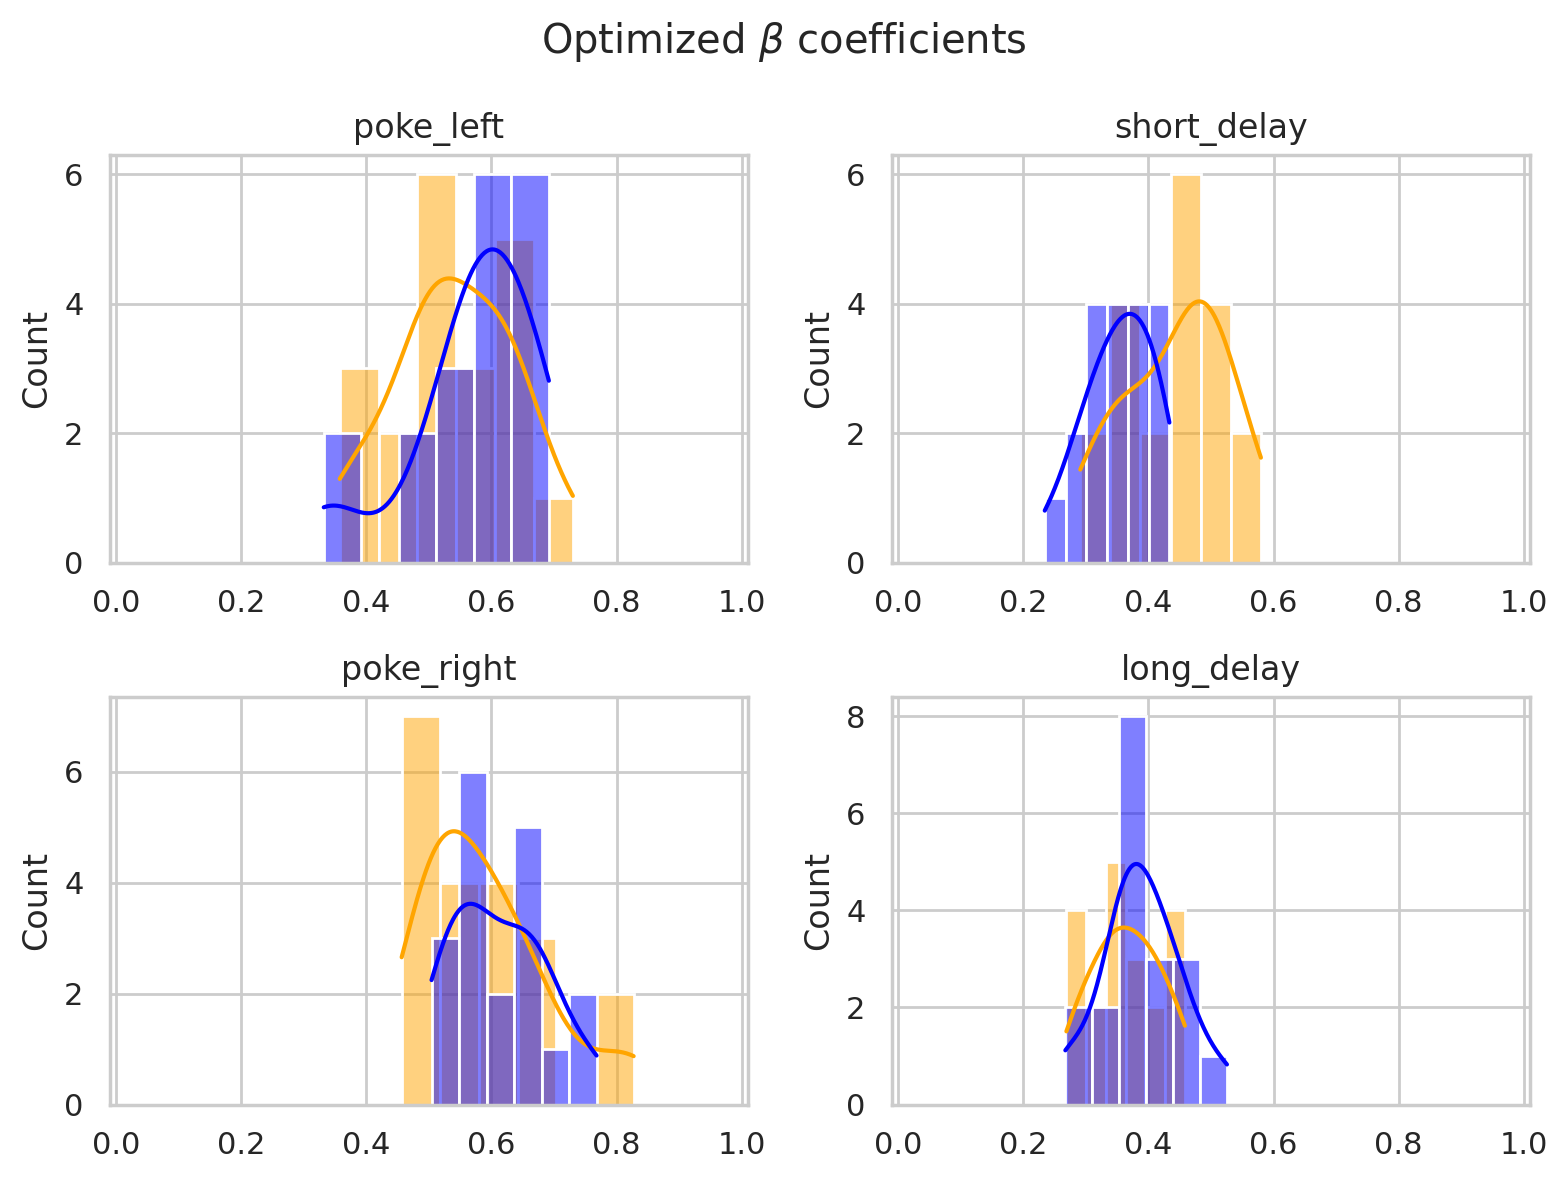

In [ ]:
for j in range(len(beta_dict.keys())):
  print(j%3,int(j/3))

0 0
1 0
2 0
0 1
1 1
2 1
0 2
1 2
2 2


In [ ]:
all_beta = {}
sns.set(style="whitegrid")

for j in range(len(beta_dict.keys())):
  all_beta[j] = [all_best_beta[i][j] for i in range(len(all_empirical_histories_in_block))]
  #fig = plt.figure()
  #plt.hist(all_beta[j])
  #ax = plt.gca()
  #plt.xlim([0,1])
  #plt.show()
  fig_beta_hist, ax_beta_hist = plt.subplots()
  sns.histplot(all_beta[j], bins='auto', kde=True, color='blue')
  ax_beta_hist.set(xlim=(-0.01,0.6))
  # Add labels and legend
  plt.xlabel(list(beta_dict.keys())[j], fontsize = 18)
  plt.ylabel('frequency', fontsize = 18)
  plt.tick_params(axis='both', which='major', labelsize=16, width=2, color='black', direction='in')

  # Show the plot
  plt.show()



In [ ]:
# fit best beta to empirical histories
from scipy.optimize import fmin_bfgs


def apply_norm_constraint(inputs):
    #return value must come back as 0 to be accepted
    #if return value is anything other than 0 it's rejected
    #as not a valid answer.
    #total = len(inputs)-np.sqrt(np.sum(np.square(inputs)))
    total = 1-np.sqrt(np.sum(np.square(inputs)))

    return total

my_constraints = ({'type': 'eq', "fun": apply_norm_constraint })

def get_best_beta_vals(emp_h,beta_dict):
  cur_opt_beta = lambda x: calc_neg_allign_coeff(emp_h,beta_dict,x)
  x0 = list(beta_dict.values())
  res=optimize.minimize(cur_opt_beta, x0, constraints=my_constraints)
  return(res.x)


x0=np.zeros(len(beta_dict.keys()))
#bnds = ((-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1))

def callbackF(Xi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}   {6: 3.6f}   {7: 3.6f}   {8: 3.6f}   {9: 3.6f}   {10: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2],Xi[3], Xi[4], Xi[5],Xi[6], Xi[7], Xi[8], opt_beta(Xi)))
    Nfeval += 1

print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}   {5:9s}   {6:9s}   {7:9s}   {8:9s}   {9:9s}   {10:9s}'.format('Iter', 'odor_left', 'odor_right', 'odor_free', 'poke_left', 'poke_right', 'no_poke', 'short_delay', 'long_delay', 'no_liquid', 'f(X)'))






all_best_beta = {}
all_best_res = {}

for i_emp, emp_h in enumerate(all_empirical_histories_in_block):
  Nfeval = 1
  cur_opt_beta = lambda x: calc_neg_allign_coeff(emp_h,beta_dict,x)
  all_best_res[i_emp] = optimize.minimize(cur_opt_beta, x0, callback=callbackF, constraints=my_constraints)
  all_best_beta[i_emp] = all_best_res[i_emp].x


# x0=[0,0, 0, 0, 0, 0, 0, 0, 0]
# [xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = \
#     fmin_bfgs(opt_beta,
#               x0,
#               callback=callbackF,
#               bounds = np.c_[-1, 1],
#               maxiter=2000,
#               full_output=True,
#               retall=False)

Iter   odor_left   odor_right   odor_free   poke_left   poke_right   no_poke     short_delay   long_delay   no_liquid   f(X)     
   1   -0.351206   -0.262059   -0.386090   -0.254307   -0.300818   -0.444229   -0.339578   -0.327950   -0.333764    0.304836
   2   -0.356972   -0.159466   -0.434257   -0.142292   -0.245338   -0.563065   -0.331210   -0.305449   -0.318329    0.255056
   3   -0.319023    0.602637   -0.679673    0.682782    0.201915   -1.280756   -0.198807   -0.078590   -0.138699   -0.153958
   4    1.002580    3.595224   -0.011933    3.820672    2.467988   -1.702788    1.340751    1.678922    1.509837   -2.329400
   5    0.207592    0.695795    0.016556    0.738248    0.483533   -0.301838    0.271270    0.334949    0.303110   -0.457400
   6    0.462978    0.472447    0.459272    0.473271    0.468330    0.453097    0.464213    0.465448    0.464831   -0.466934
   7    0.258023    0.481725    0.170488    0.501178    0.384464    0.024595    0.287202    0.316380    0.301791   -0.37

In [ ]:
plt.plot([sum(x) for x in zip(emp_cur_state_seq_list_g1[1],emp_cur_state_seq_list_g2[1])])
plt.plot(emp_cur_state_seq_list_g1[1])
plt.plot(emp_cur_state_seq_list_g2[1])
all_empirical_histories_in_block[0]
s1=emp_cur_state_seq_list_g1[0]
s2=emp_cur_state_seq_list_g2[0]

s1[170:180],s2[171:180]
all_empirical_histories_in_block[0][170:220]

all_empirical_histories_in_block[0][450:516]

NameError: ignored

In [ ]:
all_empirical_histories_in_block[0][450:516]

['odor_free',
 'poke_left',
 'long_delay',
 'odor_right',
 'poke_right',
 'short_delay',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_right',
 'short_delay',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_right',
 'short_delay',
 'odor_left',
 'poke_left',
 'long_delay',
 'odor_left',
 'poke_right',
 'no_liquid',
 'odor_left',
 'poke_right',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_left',
 'poke_right',
 'no_liquid',
 'odor_left',
 'poke_right',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid']

In [ ]:
all_empirical_histories_in_block[0]

['odor_left',
 'poke_left',
 'short_delay',
 'odor_left',
 'poke_left',
 'short_delay',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_right',
 'long_delay',
 'odor_free',
 'poke_right',
 'long_delay',
 'odor_left',
 'poke_left',
 'short_delay',
 'odor_left',
 'poke_right',
 'no_liquid',
 'odor_left',
 'poke_left',
 'short_delay',
 'odor_right',
 'poke_right',
 'long_delay',
 'odor_left',
 'poke_left',
 'short_delay',
 'odor_free',
 'poke_left',
 'short_delay',
 'odor_free',
 'poke_right',
 'long_delay',
 'odor_right',
 'poke_right',
 'long_delay',
 'odor_free',
 'poke_right',
 'long_delay',
 'odor_free',
 'poke_right',
 'long_delay',
 'odor_free',
 'poke_right',
 'long_delay',
 'odor_right',
 'poke_right',
 'long_delay',
 'odor_free',
 'poke_right',
 'long_delay',
 'odor_right',
 'poke_right',
 'long_delay',
 'odor_right',
 'poke_left',
 'no_liquid',
 'odor_right',
 'poke_right',
 'long_delay',
 'odor_free',
 'poke_right',
 

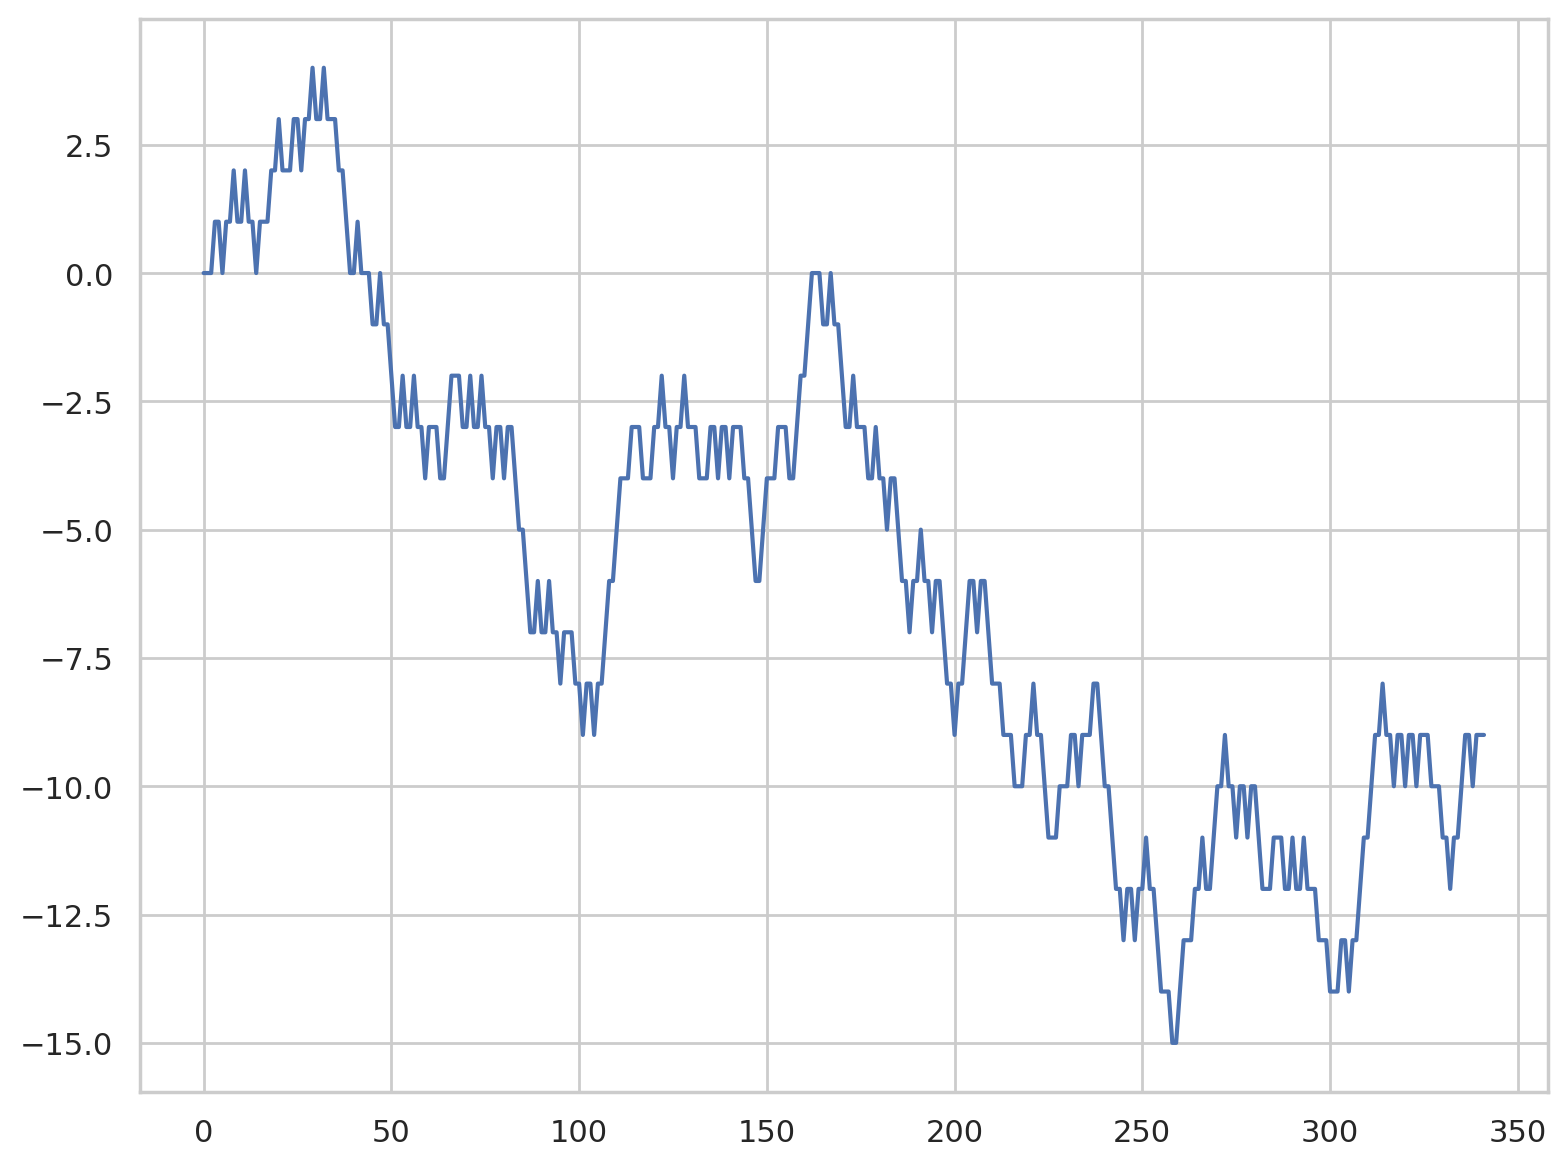

In [ ]:
 plt.plot([sum(x) for x in zip(list_g1, list_g2)])

223


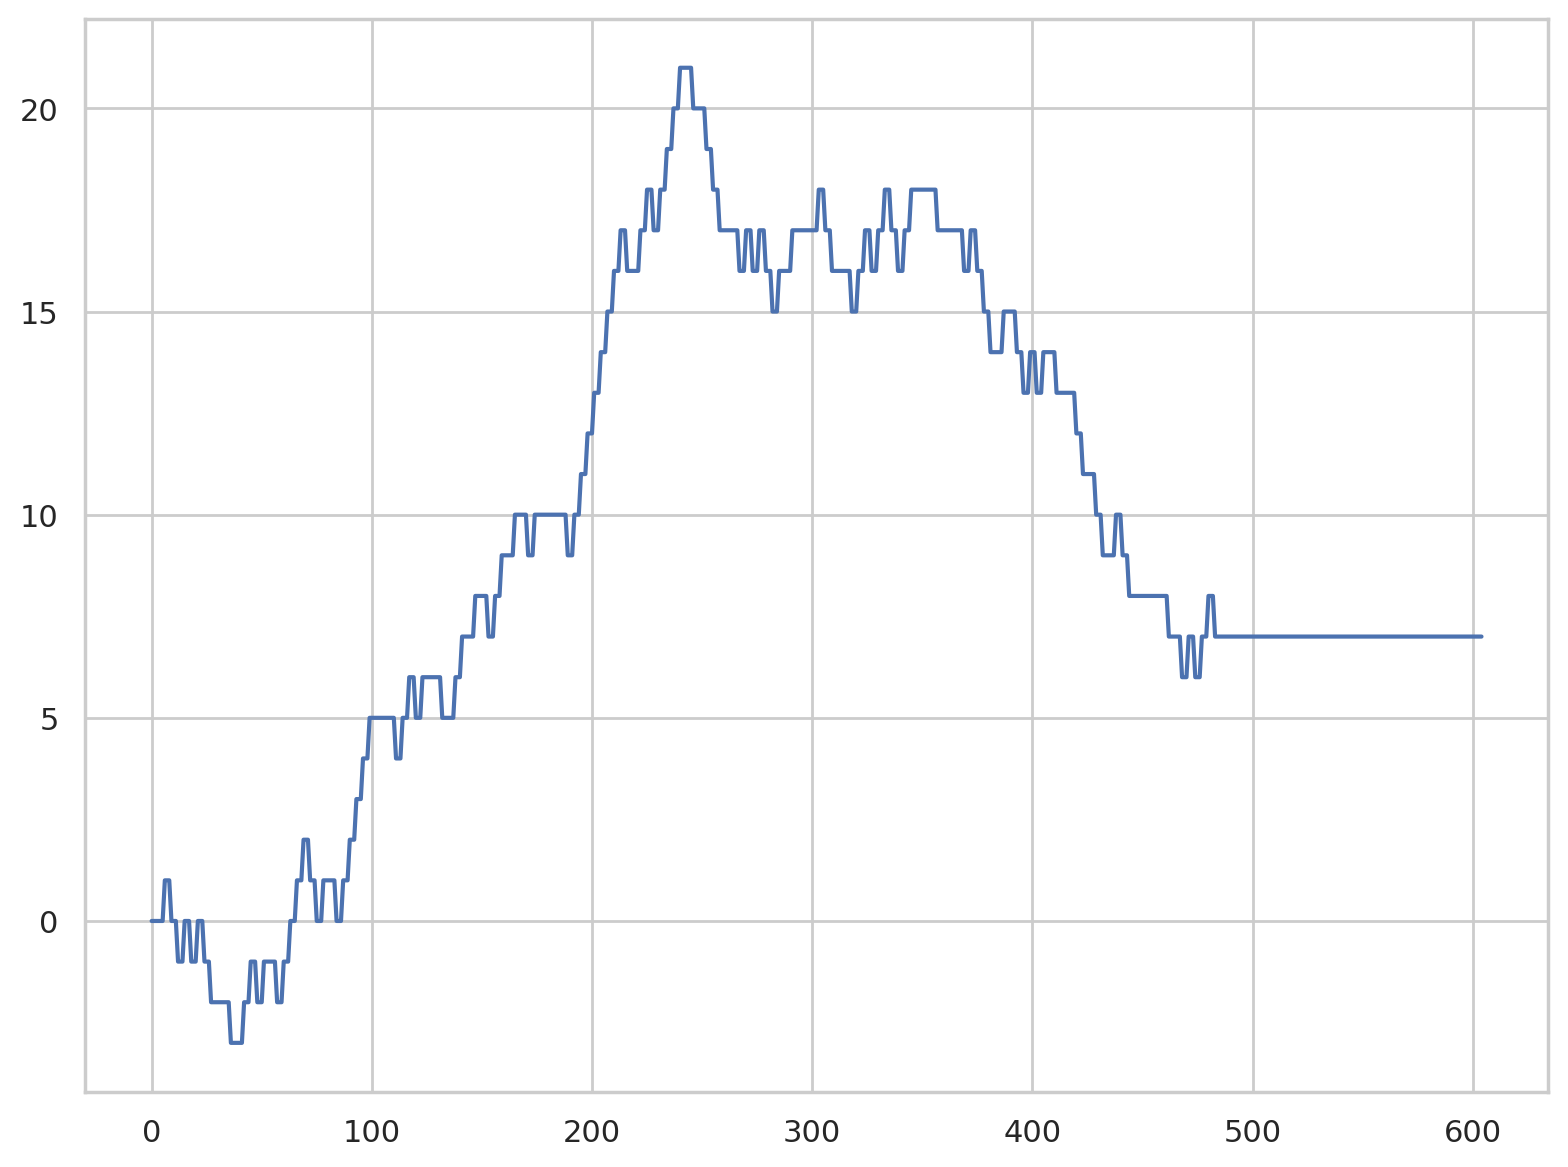

In [ ]:


print(i)
emp_h_no_const_tail = emp_h[0:-100]

plt.plot(emp_h_no_const_tail)

In [ ]:
l_emp=[len(h) for h in emp_cur_state_seq_list]
l_sim=[len(h) for h in sim_cur_state_seq_list]
l_sim,l_emp
all_empirical_histories_in_block_no_tail

[['odor_left',
  'poke_left',
  'short_delay',
  'odor_left',
  'poke_left',
  'short_delay',
  'odor_right',
  'poke_left',
  'no_liquid',
  'odor_right',
  'poke_left',
  'no_liquid',
  'odor_right',
  'poke_right',
  'long_delay',
  'odor_free',
  'poke_right',
  'long_delay',
  'odor_left',
  'poke_left',
  'short_delay',
  'odor_left',
  'poke_right',
  'no_liquid',
  'odor_left',
  'poke_left',
  'short_delay',
  'odor_right',
  'poke_right',
  'long_delay',
  'odor_left',
  'poke_left',
  'short_delay',
  'odor_free',
  'poke_left',
  'short_delay',
  'odor_free',
  'poke_right',
  'long_delay',
  'odor_right',
  'poke_right',
  'long_delay',
  'odor_free',
  'poke_right',
  'long_delay',
  'odor_free',
  'poke_right',
  'long_delay',
  'odor_free',
  'poke_right',
  'long_delay',
  'odor_right',
  'poke_right',
  'long_delay',
  'odor_free',
  'poke_right',
  'long_delay',
  'odor_right',
  'poke_right',
  'long_delay',
  'odor_right',
  'poke_left',
  'no_liquid',
  'odor_righ